# Heartbeat Sound Classification using CNN, kNN and SVM

In [233]:
# For WAV file reading
import glob
from scipy.io import wavfile

# For working of SVM and K-Neighbor Classifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# For showing sound signals spectrogram and plots
from scipy.signal import spectrogram
from matplotlib import pyplot as plt

# Machine learning standart libraries
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf

## Taking Dataset of audio recordings

In [234]:
# Dataset files should be located at the same directory with this notebook.

dataset = [{'file': file, 'class': file.split('/')[1]} 
           for file in glob.glob("Dataset/**/*.wav")]

dataframe = pd.DataFrame.from_dict(dataset)  
dataframe['data'] = dataframe['file'].apply(lambda amplitude: wavfile.read(amplitude)[1])

print("Dataset size is", dataframe['data'].size, "elements.")

Dataset size is 312 elements.


## Visualization of the dataset samples

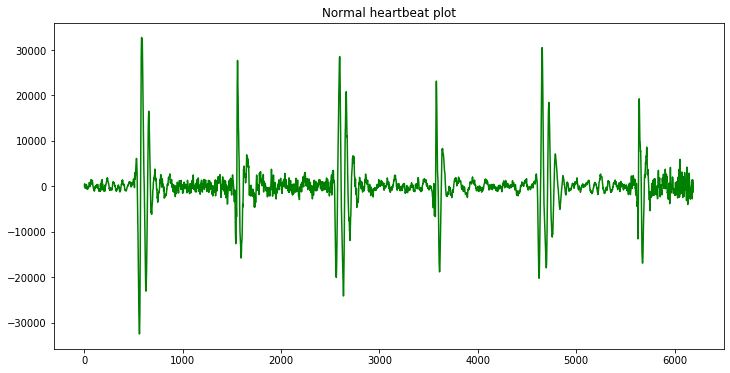

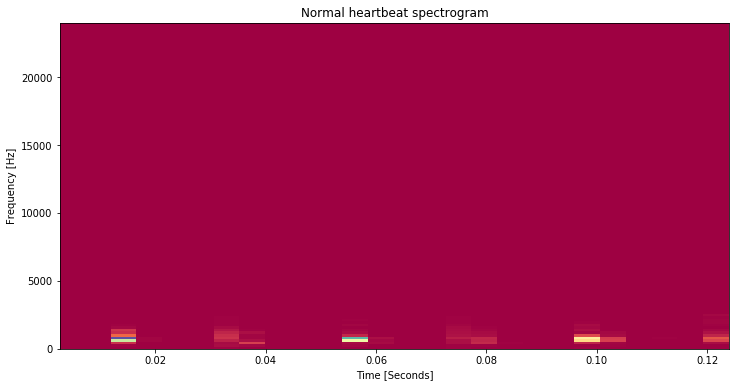

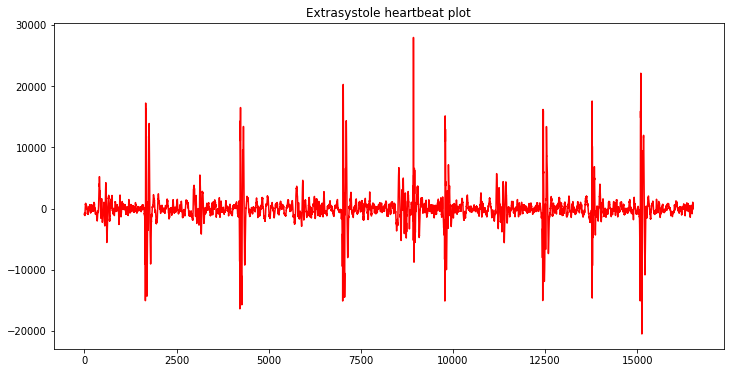

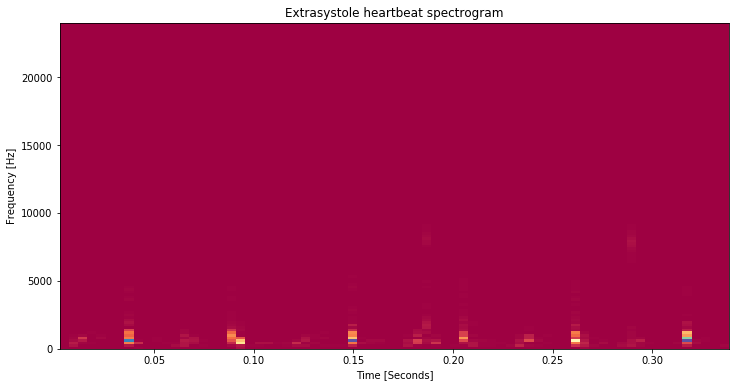

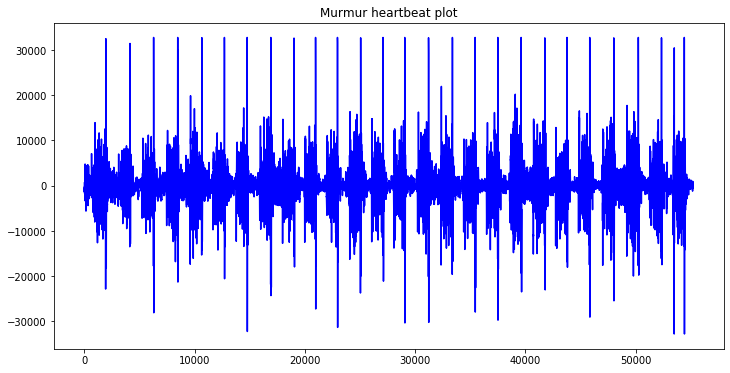

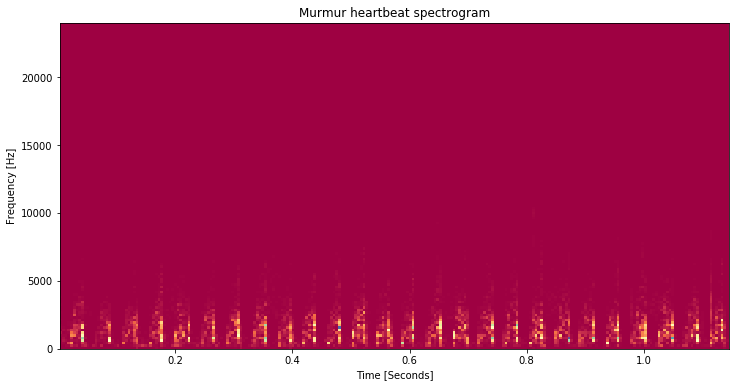

In [235]:
normal       = dataframe[dataframe['class'] == 'Normal'].sample(1)
extrasystole = dataframe[dataframe['class'] == 'Extrastole'].sample(1)
murmur       = dataframe[dataframe['class'] == 'Murmur'].sample(1)

def visualize(data, typename, color, sampling_frequency = 48000):
    # Heartbeat plot
    plt.figure(figsize=(12, 6))
    plt.title(typename + ' heartbeat plot')
    plt.plot(data.values[0], c=color)
    
    # Heartbeat spectrogram
    frequencies, times, Sxx = spectrogram(data.values[0], 48000)
    plt.figure(figsize=(12, 6))
    plt.title(typename + ' heartbeat spectrogram')
    plt.pcolormesh(times, frequencies, Sxx, cmap='Spectral')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [Seconds]')
    
visualize(normal['data'], "Normal", 'g')
visualize(extrasystole['data'], "Extrasystole", 'r')
visualize(murmur['data'], "Murmur", 'b')

## Normalization of the dataset recordings using repeating

In [236]:
maxlen = max(dataframe['data'].apply(len))

def normalize_with_repeat(array, length):
    result = np.empty(length, dtype = np.float32)
    pointer = 0
    shift = len(array)
    
    while pointer + shift <= length:
        result[pointer:pointer + shift] = array
        pointer += shift
        
    if length > pointer:
        result[pointer:length] = array[:length - pointer]
    return result

dataframe['data'] = dataframe['data'].apply(normalize_with_repeat, length=max_length)
dataframe.head(10)

,file,class,data
0,Dataset/Murmur/16.wav,Murmur,"[761.0, 359.0, 433.0, 360.0, 428.0, 560.0, 578..."
1,Dataset/Murmur/17.wav,Murmur,"[-90.0, -56.0, -26.0, -58.0, -32.0, -85.0, 45...."
2,Dataset/Murmur/15.wav,Murmur,"[-4868.0, -3575.0, -2666.0, -2053.0, -2401.0, ..."
3,Dataset/Murmur/29.wav,Murmur,"[-235.0, -315.0, -229.0, -265.0, -553.0, -395...."
4,Dataset/Murmur/28.wav,Murmur,"[-737.0, -613.0, -716.0, -595.0, -460.0, -587...."
5,Dataset/Murmur/14.wav,Murmur,"[-3157.0, -3055.0, -3158.0, -2669.0, -2073.0, ..."
6,Dataset/Murmur/38.wav,Murmur,"[379.0, 661.0, 758.0, 645.0, 568.0, 604.0, 797..."
7,Dataset/Murmur/10.wav,Murmur,"[-3344.0, -3760.0, -4558.0, -4838.0, -6230.0, ..."
8,Dataset/Murmur/11.wav,Murmur,"[1031.0, 1382.0, 1671.0, 2122.0, 2471.0, 2490...."
9,Dataset/Murmur/39.wav,Murmur,"[-248.0, -418.0, -626.0, -546.0, -237.0, -194...."


In [240]:
X = np.stack(dataframe['data'].values, axis=0)
y = np.stack(dataframe['class'].values, axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Machine learning methods for classification

### 1. SVM

In [243]:
clf = SVC(kernel='poly')
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print("Accuracy is", accuracy_score(y_test, predictions))

/Users/vladislavgadalov/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy is 0.6808510638297872


### 2. kNN

In [245]:
for n_neigh in range(2, 7):
    neigh = KNeighborsClassifier(n_neighbors=n_neigh)
    neigh.fit(X_train, y_train)
    knn_predictions = neigh.predict(X_test)
    print("Number of neighbours:", n_neigh)
    print("Accuracy is", accuracy_score(y_test, knn_predictions), "\n")

Number of neighbours: 2
Accuracy is 0.11702127659574468 

Number of neighbours: 3
Accuracy is 0.39361702127659576 

Number of neighbours: 4
Accuracy is 0.6276595744680851 

Number of neighbours: 5
Accuracy is 0.3723404255319149 

Number of neighbours: 6
Accuracy is 0.6808510638297872 



## 3. Convolutional Neural Network (CNN)

In [263]:
# Convert data to the format tf.keras expects
X_train_CNN = X_train[:,:,np.newaxis]
X_test_CNN = X_test[:,:,np.newaxis]
X_train_CNN.shape

(218, 96640, 1)

### The CNN Architecture

In [264]:
# Declare type of CNN
model = tf.keras.models.Sequential()

# Group 0 + Input
model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=9, activation='relu',
                                 input_shape = X_train_CNN.shape[1:]))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(rate=0.4))

# Group 1
model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(rate=0.35))

# Group 2
model.add(tf.keras.layers.Conv1D(filters=8, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(rate=0.3))

# Group 3
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(rate=0.25))

# Group 4
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))

# Group 5
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.15))

# Group 6
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.1))

# Output group using softmax
model.add(tf.keras.layers.GlobalAvgPool1D())
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [265]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [266]:
y_train_class_int, y_train_class_names = pd.factorize(y_train)
y_test_class_int, y_test_class_names = pd.factorize(y_test)

y_train_hot = tf.keras.utils.to_categorical(y_train_class_int)
y_test_hot = tf.keras.utils.to_categorical(y_test_class_int)

hist = model.fit(x_train, y_train_hot, 
                 epochs=30,
                 validation_data=(x_test, y_test_hot))

Train on 218 samples, validate on 94 samples
Epoch 1/30
218/218 [==============================] - 31s 142ms/sample - loss: 1.3326 - accuracy: 0.4220 - val_loss: 1.8524 - val_accuracy: 0.1064
Epoch 2/30
218/218 [==============================] - 18s 85ms/sample - loss: 1.2148 - accuracy: 0.3761 - val_loss: 1.1236 - val_accuracy: 0.4043
Epoch 3/30
218/218 [==============================] - 20s 90ms/sample - loss: 1.0463 - accuracy: 0.4404 - val_loss: 1.1191 - val_accuracy: 0.4574
Epoch 4/30
218/218 [==============================] - 20s 93ms/sample - loss: 0.9775 - accuracy: 0.5917 - val_loss: 1.0080 - val_accuracy: 0.5851
Epoch 5/30
218/218 [==============================] - 19s 88ms/sample - loss: 0.9290 - accuracy: 0.5734 - val_loss: 0.9646 - val_accuracy: 0.6702
Epoch 6/30
218/218 [==============================] - 20s 91ms/sample - loss: 0.9233 - accuracy: 0.5963 - val_loss: 0.9559 - val_accuracy: 0.6809
Epoch 7/30
218/218 [==============================] - 21s 97ms/sample - loss: 

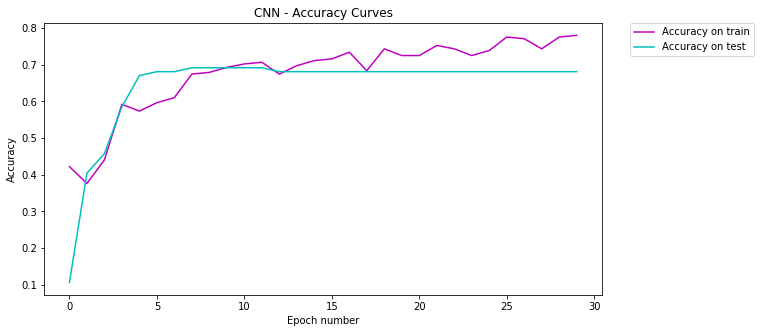

In [276]:
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

plt.figure(1, figsize=(10, 5))
plt.title('CNN - Accuracy Curves')
plt.plot(accuracy, c='m', label="Accuracy on train")
plt.plot(val_accuracy, c='c', label="Accuracy on test")
plt.ylabel('Accuracy')
plt.xlabel('Epoch number')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

In [280]:
import time
start = time.time() * 1000
model.predict(x_test)
end = time.time() * 1000
total = end - start
print("Total prediction time in ms for %d samples: %f" % (len(X_test), total))
print("Average prediction time for 1 example: %f" % (total/len(X_test)))

Total prediction time in ms for 94 samples: 2020.303955
Average prediction time for 1 example: 21.492595
